<a href="https://colab.research.google.com/github/sidrusiya/AILA_KFolds/blob/main/AILA_Task2_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import nltk
import re
import json

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import seaborn as sns
import gensim
nltk.download('all')
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from google.colab import drive
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
!pip3 install tensorflow_text
import tensorflow_text
!pip install -q tf-models-official
!pip install -q -U tensorflow-text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
import tensorflow_hub as hub
import tensorflow_text as tf_text

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

In [5]:
dataset = open('/content/drive/MyDrive/nit_agartala_nlp_team_3.tsv', 'r')
df = pd.read_csv(dataset, sep='\t')

In [6]:
df.head()

,judge_id,id,sentence,relevance,lem_text,stem_text
0,1,1,Appeal by special leave from the order dated ...,0,appeal special leave order dated government pu...,appeal special leav order date govern punjab (...
1,2,1,From the Judgment and Order dated . . of the ...,0,judgment order dated . . bombay high court app...,judgment order date . . bombay high court appe...
2,3,1,Appeal from the judgment and decree dated rd/t...,0,appeal judgment decree dated rd/th calcutta hi...,appeal judgment decre date rd/th calcutta high...
3,4,1,of .,0,.,.
4,5,1,From the Judgment and order dated . . of the ...,0,judgment order dated . . allahabad high court ...,judgment order date . . allahabad high court c...


In [7]:
df1 = df[df['judge_id'] <= 400]
df2 = df[df['judge_id'] > 400]

df1

,judge_id,id,sentence,relevance,lem_text,stem_text
0,1,1,Appeal by special leave from the order dated ...,0,appeal special leave order dated government pu...,appeal special leav order date govern punjab (...
1,2,1,From the Judgment and Order dated . . of the ...,0,judgment order dated . . bombay high court app...,judgment order date . . bombay high court appe...
2,3,1,Appeal from the judgment and decree dated rd/t...,0,appeal judgment decree dated rd/th calcutta hi...,appeal judgment decre date rd/th calcutta high...
3,4,1,of .,0,.,.
4,5,1,From the Judgment and order dated . . of the ...,0,judgment order dated . . allahabad high court ...,judgment order date . . allahabad high court c...
...,...,...,...,...,...,...
72187,27,2541,The petitioner before us does not complain tha...,0,petitioner u complain got proper grounds.,petition us complain got proper grounds.
72188,27,2542,Further the period of his detention under the ...,0,period detention impugned act gone beyond thre...,period detent impugn act gone beyond three mon...
72189,27,2543,Petition dismissed.,0,petition dismissed.,petit dismissed.
72190,27,2544,Agent for the petitioner: S. Subrahmanyam.,0,agent petitioner: s. subrahmanyam.,agent petitioner: s. subrahmanyam.


In [8]:
df2

,judge_id,id,sentence,relevance,lem_text,stem_text
400,401,1,Appeal by special leave from the judgment and ...,0,appeal special leave judgment order dated _the...,appeal special leav judgment order date _the m...
401,402,1,Appeal from Judgment and Order dated the th da...,0,appeal judgment order dated th day june high c...,appeal judgment order date th day june high co...
402,403,1,Appeal by Special leave from the Judgment and ...,0,appeal special leave judgment order dated rd j...,appeal special leav judgment order date rd jan...
403,404,1,From the Judgment and Order dated . . of the ...,0,judgment order dated . . andhra pradesh admini...,judgment order date . . andhra pradesh adminis...
404,405,1,Appeal by Special Leave from the Award of the ...,0,appeal special leave award industrial tribunal...,appeal special leav award industri tribun guja...
...,...,...,...,...,...,...
69217,409,1201,The interim orders passed by this Court are va...,0,interim order passed court vacated.,interim order pass court vacated.
69223,409,1202,The amount of rupees which the Indian shareho...,0,amount rupee indian shareholder directed pay h...,amount rupe indian sharehold direct pay hold c...
69229,409,1203,The interim Board of Directors shall forthwith...,1,interim board director shall forthwith hand ch...,interim board director shall forthwith hand ch...
69235,409,1204,After taking the charge from the interim Board...,0,taking charge interim board board director tak...,take charg interim board board director take e...


In [9]:
max_classes = len(df.relevance.unique())
max_length=128

In [10]:
!pip3 install transformers
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

# Same as before
checkpoint = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(checkpoint, max_length=max_length)

     |████████████████████████████████| 3.3 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 40.6 MB/s 
     |████████████████████████████████| 3.3 MB 36.5 MB/s 
     |████████████████████████████████| 61 kB 514 kB/s 


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [11]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

EPOCHS = 3
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
batch_size = 32

# num_train_steps =  len((balanced_df.NumLabel) // batch_size) * EPOCHS
# lr_scheduler = PolynomialDecay(initial_learning_rate=5e-5,
#                                end_learning_rate=0.,
#                                decay_steps=num_train_steps
#                                )

from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=5e-5)

In [17]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
result = shuffle(df1)

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(result.lem_text, result.relevance, 
                                                    test_size = 0.1, random_state = 42, stratify =result.relevance)

In [19]:
max_classes = len(df.relevance.unique())
print(max_classes)

2


In [20]:
%%time
encoded_labels_train = to_categorical(Y_train, num_classes=max_classes)
encoded_labels_test = to_categorical(Y_test, num_classes=max_classes)

CPU times: user 1.98 ms, sys: 0 ns, total: 1.98 ms
Wall time: 1.85 ms


In [21]:
def roberta_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  

  for i in tqdm(range(len(data))):
      encoded = tokenizer.encode_plus(
        
        data[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [22]:
!pip install tqdm
from tqdm import *
%time
train_inputs,train_attention_masks = roberta_encode(list(X_train), max_length)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


  0%|          | 0/53892 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 53892/53892 [00:25<00:00, 2130.03it/s]


In [23]:
test_inputs,test_attention_masks = roberta_encode(list(X_test), max_length)

  0%|          | 0/5988 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 5988/5988 [00:02<00:00, 2295.21it/s]


In [24]:
print(f'Number of Samples in Training Set : {len(X_train)} Number of Samples in Validation Set: {len(X_test)} ')

Number of Samples in Training Set : 53892 Number of Samples in Validation Set: 5988 


In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!mkdir checkpoints
filepath = "RoBERT-lemm-{epoch:02d}.h5"
MyCheckpoint = ModelCheckpoint(filepath,
                               monitor = 'val_categorical_accuracy',
                               verbose = 1,
                               save_best_only = True,
                               mode='auto',
                               save_weights_only = True)

MyEarlyStopping = EarlyStopping(patience =1,
                                monitor='val_categorical_accuracy',
                                restore_best_weights = True,
                                verbose = 1)

ModelSaver = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

In [26]:
from sklearn.utils import class_weight
class_weights_array = class_weight.compute_class_weight(class_weight='balanced'
                                               ,classes=np.unique(df1.relevance)
                                               ,y=df1.relevance)

class_weights_array

array([0.6463312, 2.2084532])

In [27]:
class_weights = {i : class_weights_array[i] for i in range(len(class_weights_array))}
class_weights

{0: 0.6463311961660514, 1: 2.2084531976100905}

In [28]:
# !pip install tensorflow_addons
# import tensorflow_addons as tfa

# macro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='macro')
# micro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='micro')
# weighted_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='weighted')
precision = tf.metrics.Precision()
recall = tf.metrics.Recall()
categorical_accuracry = tf.metrics.CategoricalAccuracy()

class F1_metric(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        # Initialize our metric by initializing the two metrics it's based on:
        # Precision and Recall
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update our metric by updating the two metrics it's based on
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
        # To get the F1 result, we compute the harmonic mean of the current
        # precision and recall
        return 2 / ((1 / self.precision.result()) + (1 / self.recall.result())) 

F1Score = F1_metric()
metrics = [categorical_accuracry, F1Score]

In [29]:
def create_model(roberta_model):
  input_ids = tf.keras.Input(shape=(max_length,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(max_length,),dtype='int32')
  
  output = roberta_model([input_ids,attention_masks])
  output = output[1]
  
#   output = tf.keras.layers.Dense(128,activation='relu',)(output)
#   output = tf.keras.layers.Dropout(0.2)(output)
#   output = tf.keras.layers.BatchNormalization()(output)

#   output = tf.keras.layers.Dense(64,activation='relu',)(output)
#   output = tf.keras.layers.Dropout(0.2)(output)
#   output = tf.keras.layers.BatchNormalization()(output)

  output = tf.keras.layers.Dense(32,activation='relu')(output)
  output = tf.keras.layers.Dropout(0.2)(output)
  
  output = tf.keras.layers.Dense(units=max_classes,activation='softmax')(output)
  model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
  model.compile(optimizer= opt,
              loss= loss,
              metrics = metrics)
  return model

In [30]:
from transformers import TFRobertaModel
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

model = create_model(roberta_model)
model.summary()

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [31]:
%%time
history = model.fit([train_inputs,train_attention_masks], encoded_labels_train, 
                    validation_data=([test_inputs, test_attention_masks], encoded_labels_test),
                    epochs = EPOCHS,
                    batch_size = 32,
                    verbose = 1,
                    class_weight=class_weights,
                    callbacks = [MyCheckpoint, MyEarlyStopping]
                    )

Epoch 1/3
1685/1685 [==============================] - ETA: 0s - loss: 0.6938 - categorical_accuracy: 0.6530 - f1_score: 0.6530
Epoch 00001: val_categorical_accuracy improved from -inf to 0.22645, saving model to RoBERT-lemm-01.h5
1685/1685 [==============================] - 2611s 2s/step - loss: 0.6938 - categorical_accuracy: 0.6530 - f1_score: 0.6530 - val_loss: 0.6933 - val_categorical_accuracy: 0.2265 - val_f1_score: 0.2265
Epoch 2/3
1685/1685 [==============================] - ETA: 0s - loss: 0.6931 - categorical_accuracy: 0.3889 - f1_score: 0.3889
Epoch 00002: val_categorical_accuracy did not improve from 0.22645
Restoring model weights from the end of the best epoch: 1.
1685/1685 [==============================] - 2549s 2s/step - loss: 0.6931 - categorical_accuracy: 0.3889 - f1_score: 0.3889 - val_loss: 0.6934 - val_categorical_accuracy: 0.2265 - val_f1_score: 0.2265
Epoch 00002: early stopping
CPU times: user 29min 19s, sys: 9min 20s, total: 38min 40s
Wall time: 1h 26min


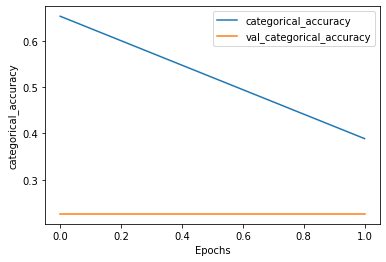

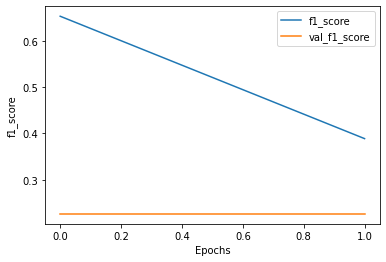

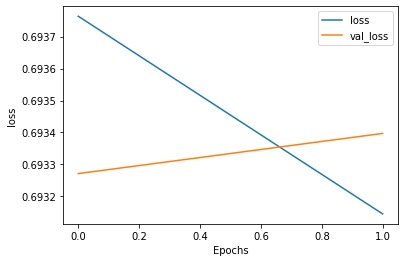

In [32]:
import matplotlib.pyplot as plt 
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "categorical_accuracy")
plot_graphs(history, "f1_score")
plot_graphs(history, 'loss')

In [33]:
model.load_weights('./RoBERT-lemm-01.h5')
final_test_inputs, final_test_attention_masks = roberta_encode(list(df2.lem_text), max_length)
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

df2['pred_labels_cleaned_e1'] = y_preds

  0%|          | 0/12312 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 12312/12312 [00:05<00:00, 2349.76it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9288
           1       0.25      1.00      0.39      3024

    accuracy                           0.25     12312
   macro avg       0.12      0.50      0.20     12312
weighted avg       0.06      0.25      0.10     12312



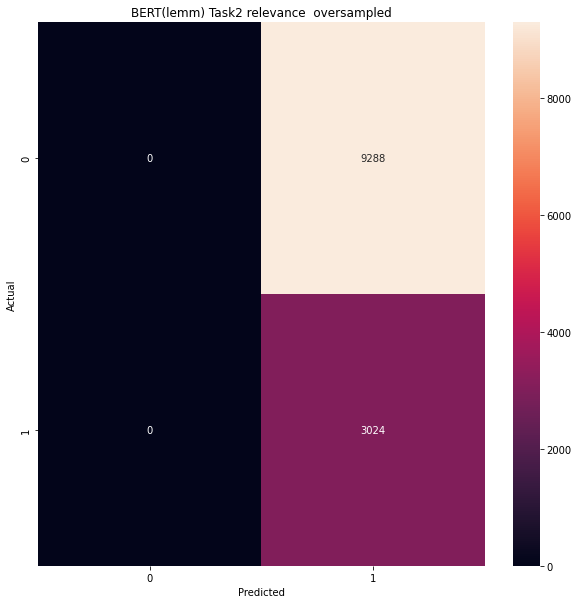

In [35]:
from sklearn.metrics import classification_report
print(classification_report(df2.relevance,df2.pred_labels_cleaned_e1))

import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(list(df2.relevance), list(df2['pred_labels_cleaned_e1']))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(df2.relevance), yticklabels=set(df2.relevance))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('BERT(lemm) Task2 relevance  oversampled')
plt.show()



In [36]:
summary_file= pd.DataFrame(columns=['judge_id', 'summary', 'pred_summary_1', 'pred_summary_2', 'pred_summary_3'])
for i in range(100):
      summary_file= summary_file.append({'judge_id': i+401,  'summary': '', 'pred_summary_1': '', 'pred_summary_2': '', 'pred_summary_3': ''}, ignore_index=True)

In [37]:
for i in df2.index:
  if df2['relevance'][i]:
    summary_file['summary'][df2['judge_id'][i]-401]+=(df2['sentence'][i])
  if df2['pred_labels_cleaned_e1'][i]:
    summary_file['pred_summary_1'][df2['judge_id'][i]-401]+=(df2['sentence'][i])
  

summary_file

,judge_id,summary,pred_summary_1,pred_summary_2,pred_summary_3
0,401,The appellant is a firm consisting of six part...,Appeal by special leave from the judgment and ...,,
1,402,Sannyasi charan Sadhukhan died in and his son...,Appeal from Judgment and Order dated the th da...,,
2,403,The following question of law had been referre...,Appeal by Special leave from the Judgment and ...,,
3,404,Special leave granted.Pending prosecution with...,From the Judgment and Order dated . . of the ...,,
4,405,In the case of the Alembic Glass Industries li...,Appeal by Special Leave from the Award of the ...,,
...,...,...,...,...,...
95,496,Punjab Excise Act has been extended to Delhi....,From the Judgment and Order dated -- of the De...,,
96,497,In support of his first contention reliance wa...,Appeal from the Judgment and Decree dated the ...,,
97,498,These appointments seem to have been made vari...,From the Judgment and Order dated . . of the ...,,
98,499,The revenue authorities sanctioned mutation of...,Appeal from the judgment and decree dated of...,,


In [38]:
!pip install rouge

from rouge import Rouge

rouge = Rouge()

In [39]:
rouge_scores= pd.DataFrame(columns=['r1_f', 'r1_p', 'r1_r', 'r2_f', 'r2_p', 'r2_r', 'rl_f', 'rl_p', 'rl_r'])

#for i in range(100):
  #rouge_scores= rouge_scores.append({'r1_f': 0.0 , 'r1_p': 0.0 , 'r1_r': 0.0 , 'r2_f': 0.0 , 'r2_p': 0.0 , 'r2_r': 0.0 , 'rl_f': 0.0 , 'rl_p': 0.0 , 'rl_r': 0.0 }, ignore_index=True)


for i in summary_file.index:
    if(summary_file['summary'][i]==''):
      summary_file['summary'][i]+="Empty"
    if(summary_file['pred_summary_1'][i]==''):
      summary_file['pred_summary_1'][i]+="Empty"
    scores = rouge.get_scores(summary_file['pred_summary_1'][i], summary_file['summary'][i])
    rouge_scores= rouge_scores.append({'r1_f': scores[0]['rouge-1']['f'] , 'r1_p': scores[0]['rouge-1']['p'] , 'r1_r': scores[0]['rouge-1']['r'] , 'r2_f': scores[0]['rouge-2']['f'] , 'r2_p': scores[0]['rouge-2']['p'] , 'r2_r': scores[0]['rouge-2']['r'] , 'rl_f': scores[0]['rouge-l']['f'] , 'rl_p': scores[0]['rouge-l']['p'] , 'rl_r': scores[0]['rouge-l']['r'] }, ignore_index=True)


rouge_scores

,r1_f,r1_p,r1_r,r2_f,r2_p,r2_r,rl_f,rl_p,rl_r
0,0.629523,0.459346,1.000000,0.522458,0.356111,0.980445,0.629523,0.459346,1.000000
1,0.371889,0.228417,1.000000,0.279123,0.162634,0.983740,0.371889,0.228417,1.000000
2,0.664547,0.498212,0.997613,0.570238,0.401034,0.986429,0.664547,0.498212,0.997613
3,0.660352,0.492929,1.000000,0.569620,0.401070,0.982533,0.660352,0.492929,1.000000
4,0.505263,0.338028,1.000000,0.422499,0.268852,0.985972,0.505263,0.338028,1.000000
...,...,...,...,...,...,...,...,...,...
95,0.761261,0.614545,1.000000,0.707826,0.551061,0.989242,0.761261,0.614545,1.000000
96,0.461103,0.299632,1.000000,0.366942,0.225610,0.982301,0.461103,0.299632,1.000000
97,0.627615,0.457317,1.000000,0.511075,0.345004,0.985417,0.627615,0.457317,1.000000
98,0.508217,0.341256,0.995050,0.434043,0.278689,0.980769,0.508217,0.341256,0.995050


In [40]:
r1mean_f = rouge_scores['r1_f'].mean()
print('rouge-1 AVERAGE_F is',r1mean_f)
r1mean_p = rouge_scores['r1_p'].mean()
print('rouge-1 AVERAGE_P is',r1mean_p)
r1mean_r = rouge_scores['r1_r'].mean()
print('rouge-1 AVERAGE_R is',r1mean_r)
r2mean_f = rouge_scores['r2_f'].mean()
print('rouge-2 AVERAGE_F is',r2mean_f)
r2mean_p = rouge_scores['r2_p'].mean()
print('rouge-2 AVERAGE_P is',r2mean_p)
r2mean_r = rouge_scores['r2_r'].mean()
print('rouge-2 AVERAGE_R is',r2mean_r)
rlmean_f = rouge_scores['rl_f'].mean()
print('rouge-l AVERAGE_F is',rlmean_f)
rlmean_p = rouge_scores['rl_p'].mean()
print('rouge-l AVERAGE_P is',rlmean_p)
rlmean_r = rouge_scores['rl_r'].mean()
print('rouge-l AVERAGE_R is',rlmean_r)

rouge-1 AVERAGE_F is 0.5418680213403778
rouge-1 AVERAGE_P is 0.38595767039684703
rouge-1 AVERAGE_R is 0.9886858280464226
rouge-2 AVERAGE_F is 0.4469697042893037
rouge-2 AVERAGE_P is 0.3032429965252823
rouge-2 AVERAGE_R is 0.973140717280242
rouge-l AVERAGE_F is 0.5418171164625689
rouge-l AVERAGE_P is 0.38592092996056443
rouge-l AVERAGE_R is 0.9886020959861297
